In [1]:
import numpy as np
from matplotlib import cycler, pyplot as plt, ticker
import networkx as nx

import scipy
import time
import random

from abc import ABC, abstractmethod
from collections import Counter
from operator import itemgetter

from IPython.display import Image

In [2]:
PLOT_SIZE_X = 10
PLOT_SIZE_Y = 5
PLOT_LEFT_POS = 0.1
PLOT_RIGHT_POS = 0.9
PLOT_BOTTOM_POS = 0.15
PLOT_TOP_POS = 0.85
PLOT_MARGIN = 0.01
PLOT_LW = 0.9
PLOT_GRID_LW = 0.2
PLOT_TICKS_Y_INTERVAL = 0.1
PLOT_TICKS_MINOR_Y_INTERVAL = PLOT_TICKS_Y_INTERVAL / 5
PLOT_SAVE = False


def plot_history(best_history, avg_history, worst_history, pop_size, p_co, p_m,
         filename, y_ticks_interval=PLOT_TICKS_Y_INTERVAL, y_min=0.5, y_max=1, lloc='best'):

    colors = cycler('color', ['olive', 'dodgerblue', 'orange'])
    n = len(best_history)
    plt.rc('axes', prop_cycle=colors)

    fig, ax = plt.subplots(figsize=(PLOT_SIZE_X, PLOT_SIZE_Y))
    plt.subplots_adjust(left=PLOT_LEFT_POS, right=PLOT_RIGHT_POS, bottom=PLOT_BOTTOM_POS, top=PLOT_TOP_POS)
    plt.margins(x=PLOT_MARGIN)

    x = np.arange(0, n)
    plt.plot(x, best_history, label='best', linewidth=PLOT_LW)
    plt.plot(x, avg_history, label='avg', linewidth=PLOT_LW)
    plt.plot(x, worst_history, label='worst', linewidth=PLOT_LW)
    plt.title(
        f"Fitness over generations (n={pop_size}, p_co={p_co}, p_m={p_m})")

    plt.xlabel("Generation")
    plt.ylabel("Fitness")

    legend = plt.legend(loc=lloc)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('white')

    plt.grid(axis='y', lw=PLOT_GRID_LW)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(n / 10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(n / 100))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(y_ticks_interval))
    # ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_ticks_interval / 5))
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=n - 1)
    # ax.set_ylim(ymax=y_max)
    # ax.set_ylim(ymin=y_min)

    if PLOT_SAVE:
        plt.savefig(filename + '.png')
    plt.show()


In [3]:
class Graph:
    def __init__(self, n=7, p=0.5, adjacent_matrix=None):

        if adjacent_matrix is None:
            self.graph = nx.fast_gnp_random_graph(n, p)
        else:
            self.graph = nx.from_numpy_matrix(adjacent_matrix)

        self.adjacency_matrix = scipy.sparse.triu(nx.to_scipy_sparse_array(self.graph))
        self.color_map = []

    def show(self):
        plt.axis('equal')
        if self.color_map:
            nx.draw(self.graph, node_color=self.color_map, with_labels=True)
        else:
            nx.draw(self.graph, with_labels=True)
        plt.show()

    def __len__(self):
        return len(self.graph.nodes)

In [4]:
COLORS = ['orange', 'y', 'skyblue', 'rebeccapurple', 'orangered', 'gold', 'dodgerblue', 'palevioletred', 'slategray',
          'lavenderblush']


class GCP:
    def __init__(self, graph, k, ff='basic'):
        self.chromatic_number = k
        self.graph = graph
        self.ff = ff

    def get_solution_props(self):
        return len(self.graph), self.chromatic_number

    def set_graph_colors(self, solution):
        color_map = []

        for color_index in solution:
            color_map.append(COLORS[color_index])

        self.graph.color_map = color_map

    def is_valid_solution(self, solution):
        return self.non_valid_edges_count(solution) == 0

    def valid_edges_count(self, solution):
        count = 0
        for v1, v2 in zip(self.graph.adjacency_matrix.row, self.graph.adjacency_matrix.col):
            if solution[v1] != solution[v2]:
                count += 1
        return count

    def non_valid_edges_count(self, solution):
        count = 0
        for v1, v2 in zip(self.graph.adjacency_matrix.row, self.graph.adjacency_matrix.col):
            if solution[v1] == solution[v2]:
                count += 1
        return count

    def fitness_function(self, solution):
        match self.ff:
            case 'less_colors':
                return self.fitness_function_less_colors(solution)
            case 'balanced':
                return self.fitness_function_balanced(solution)
            case _:
                return self.fitness_function_basic(solution)

    def fitness_function_basic(self, solution):
        return 1 / (self.non_valid_edges_count(solution) + 1)

    def fitness_function_balanced(self, solution):
        edges_size = len(self.graph.graph.edges)
        nodes_size = len(self.graph.graph.nodes)

        occurrences = Counter(solution).values()
        color_factor = 1
        for color_occurrences in occurrences:
            color_factor *= color_occurrences / nodes_size

        return (self.valid_edges_count(solution) / edges_size) + color_factor

    def fitness_function_less_colors(self, solution):
        used_colors = len(set(solution))
        return 1 / (self.non_valid_edges_count(solution) + 1) * 1 / used_colors

    def plot_graph(self):
        self.graph.show()

In [5]:
class Optimizer(ABC):
    def __init__(self, problem):
        self.problem = problem

        self.iteration = 0
        self.stop_conditions = []

        self.best_solution_history = []
        self.best_fitness_history = []
        self.worst_fitness_history = []
        self.best_solution = None
        self.best_fitness = 0

    def fitness_function(self, solution):
        return self.problem.fitness_function(solution)

    def add_stop_condition(self, sc):
        self.stop_conditions.append(sc)
        sc.optimizer = self

    def is_stop_condition_satisfied(self):
        for sc in self.stop_conditions:
            if sc.is_stop():
                return True
        return False


class GeneticAlgorithm(Optimizer):
    def __init__(self, problem, population_size=100):
        super().__init__(problem)
        self.population_size = population_size
        self.chromosome_size, self.max_gene_value = self.problem.get_solution_props()
        self.population = None

        self.avg_fitness_history = []
        self.selection_op = None
        self.crossover_op = None
        self.mutation_op = None
        
        self.best_generation = 0
        self.best_time = 0

    def optimize(self, plot=True):
        self.population = Population(self.chromosome_size, self.population_size, self.max_gene_value)
        self.population.fitness = self.get_population_fitness()
        self.best_time = time.time()

        while not self.is_stop_condition_satisfied():
            parents = self.selection_op.get_parents(self.population)
            children = self.crossover_op.get_children(parents)
            children = self.mutation_op.mutate_population(children, self.max_gene_value)

            self.population.individuals = children
            self.population.fitness = self.get_population_fitness()

            self.log()
            self.iteration += 1

        if(plot):
            plot_history(self.best_fitness_history, self.avg_fitness_history, self.worst_fitness_history, 
                 self.population_size, self.crossover_op.p, self.mutation_op.p, './plots/plot')
        
        return self.best_solution

    def set_selection_method(self, selection):
        self.selection_op = selection

    def get_population_fitness(self):
        fitness = []

        for individual in self.population:
            fitness.append(self.problem.fitness_function(individual))

        return fitness

    def log(self):
        avg_fitness = np.average(self.population.fitness)
        self.avg_fitness_history.append(avg_fitness)

        best_in_generation = self.population[np.argmax(self.population.fitness)]
        best_in_generation_fitness = max(self.population.fitness)
        worst_in_generation_fitness = min(self.population.fitness)
        self.best_solution_history.append(best_in_generation)
        self.best_fitness_history.append(best_in_generation_fitness)
        self.worst_fitness_history.append(worst_in_generation_fitness)

        if best_in_generation_fitness > self.best_fitness:
            self.best_fitness = best_in_generation_fitness
            self.best_solution = best_in_generation
        
        if not self.best_generation and self.best_fitness == 1:
            self.best_generation = self.iteration
            self.best_time = time.time() - self.best_time

In [6]:
class Population:
    def __init__(self, gene_num, population_size, k=2):
        self.individuals = np.random.randint(0, k, (population_size, gene_num), dtype=np.int8)
        self.fitness = np.empty(population_size)
        self.k = k

    def __str__(self):
        return self.individuals.__str__()

    def __len__(self):
        return self.individuals.shape[0]

    def __getitem__(self, item):
        return self.individuals[item]

    def __iter__(self):
        return PopulationIterator(self)


class PopulationIterator:
    def __init__(self, population):
        self._population = population
        self._index = 0

    def __next__(self):
        if self._index < len(self._population):
            result = self._population[self._index]
            self._index += 1
            return result
        raise StopIteration

In [7]:
class StopCondition(ABC):
    def __init__(self):
        self.optimizer = None

    @abstractmethod
    def is_stop(self):
        pass


class StopAfterNIterations(StopCondition):
    def __init__(self, n):
        super().__init__()
        self.max_iters = n

    def is_stop(self):
        return self.optimizer.iteration >= self.max_iters


class StopAfterTime(StopCondition):
    def __init__(self, max_time=60):
        super().__init__()
        self.start_time = None
        self.max_time = max_time

    def is_stop(self):
        is_stop_condition_satisfied = False

        if not self.start_time:
            self.start_time = time.time()
        else:
            if time.time() >= self.start_time + self.max_time:
                is_stop_condition_satisfied = True
                self.start_time = None

        return is_stop_condition_satisfied


class StopWhenFit(StopCondition):
    def __init__(self, expected_fitness=100):
        super().__init__()
        self.expected_fitness = expected_fitness

    def is_stop(self):
        return self.optimizer.best_fitness <= self.expected_fitness

In [8]:
class Selection(ABC):

    @abstractmethod
    def _index_generator(self, population):
        pass

    def get_parents(self, population):
        parents = []

        for i in self._index_generator(population):
            parents.append(population[i])

        return np.array(parents)


class RandomSelection(Selection):
    def __init__(self, seed=42):
        super().__init__()
        np.random.seed(seed)

    def _index_generator(self, population):
        for _ in population:
            yield np.random.randint(len(population))


class RouletteWheelSelection(Selection):

    def _index_generator(self, population):
        fitness_sum = sum(population.fitness)
        proportions = np.array(population.fitness) / fitness_sum

        for _ in population:
            yield np.random.choice(range(len(population)), p=proportions)


class TournamentSelection(Selection):
    def __init__(self, k):
        super().__init__()
        self.k = k

    def _index_generator(self, population):
        for _ in population:
            k_indices = random.sample(range(len(population)), self.k)
            k_group = [(i, population.fitness[i]) for i in k_indices]
            yield max(k_group, key=itemgetter(1))[0]


class StochasticSelection(Selection):

    def _index_generator(self, population):
        fitness_scale = []
        pointers = []
        pointer_step = sum(population.fitness) / len(population)
        offset = np.random.uniform(0, pointer_step)

        for i, fitness in enumerate(population.fitness):
            if i == 0:
                fitness_scale.append(fitness)
                pointers.append(offset)
            else:
                fitness_scale.append(fitness + fitness_scale[i - 1])
                pointers.append(pointers[i - 1] + pointer_step)

        i = 0
        for p in pointers:
            while fitness_scale[i] < p:
                i += 1
            yield i


def set_population_fitness(population):
    fitness = []
    for chromosome in population:
        fitness.append(sum(chromosome))
    return fitness

In [9]:
def pair_generator(population_size):
    indices = [i for i in range(population_size)]
    np.random.shuffle(indices)
    for _ in range(population_size // 2):
        yield [indices.pop(), indices.pop()]


class Crossover(ABC):
    def __init__(self, p=0.4):
        self.p = p

    @abstractmethod
    def cross(self, parent1, parent2):
        pass

    def get_children(self, parents):
        population_size = len(parents)
        children = []

        for parent1, parent2 in pair_generator(population_size):
            if np.random.rand() <= self.p:
                child1, child2 = self.cross(parents[parent1], parents[parent2])
                children.append(child1)
                children.append(child2)
            else:
                children.append(parents[parent1])
                children.append(parents[parent2])

        return np.array(children)


class SinglePointCrossover(Crossover):
    def __init__(self, p=0.4):
        super().__init__(p)

    def cross(self, parent1, parent2):
        chromosome_size = len(parent1)
        locus = np.random.randint(chromosome_size)

        child1 = np.concatenate((parent1[:locus], parent2[locus:]))
        child2 = np.concatenate((parent2[:locus], parent1[locus:]))

        return child1, child2


class MultiPointCrossover(Crossover):
    def __init__(self, locus_count, p=0.4):
        super().__init__(p)
        self.locus_count = locus_count

    def cross(self, parent1, parent2):
        chromosome_size = len(parent1)
        loci = [np.random.randint(chromosome_size) for _ in range(self.locus_count)]
        loci.sort()
        prev_locus = 0

        child1_genes = []
        child2_genes = []

        for locus in loci:
            child1_genes.append(parent1[prev_locus:locus])
            child2_genes.append(parent2[prev_locus:locus])

            parent1, parent2 = parent2, parent1
            prev_locus = locus

        child1_genes.append(parent1[prev_locus:])
        child2_genes.append(parent2[prev_locus:])

        return np.concatenate(child1_genes), np.concatenate(child2_genes)


class UniformCrossover(Crossover):
    def __init__(self, p=0.4):
        super().__init__(p)

    def cross(self, parent1, parent2):
        chromosome_size = len(parent1)

        child1_genes = []
        child2_genes = []
        parents = [parent1, parent2]

        for i in range(chromosome_size):
            gene_activator = np.random.randint(2)
            child1_genes.append(parents[gene_activator][i])
            child2_genes.append(parents[abs(gene_activator - 1)][i])

        return np.array(child1_genes), np.array(child2_genes)

In [10]:
class Mutation(ABC):
    def __init__(self, p=0.2):
        self.p = p
        self.loci = None
        self.domain_max = None

    @abstractmethod
    def mutate_individual(self, individual):
        pass

    def set_loci(self, chromosome_size):
        loci = random.sample(range(chromosome_size), 2)
        loci.sort()
        self.loci = loci

    def mutate_population(self, population, max_value=1):
        mutated = []
        self.domain_max = max_value

        for chromosome in population:
            if np.random.rand() <= self.p:
                self.set_loci(len(chromosome))
                mutated.append(self.mutate_individual(np.array(chromosome)))
            else:
                mutated.append(chromosome)

        return np.array(mutated)


class RandomResetting(Mutation):

    def mutate_individual(self, chromosome):
        chromosome[self.loci[0]] = np.random.randint(self.domain_max)
        return chromosome


class SwapMutation(Mutation):

    def mutate_individual(self, chromosome):
        chromosome[self.loci[0]], chromosome[self.loci[1]] = chromosome[self.loci[1]], chromosome[self.loci[0]]
        return chromosome


class ScrambleMutation(Mutation):

    def mutate_individual(self, chromosome):
        np.random.shuffle(chromosome[self.loci[0]:self.loci[1]])
        return chromosome


class InversionMutation(Mutation):

    def mutate_individual(self, chromosome):
        chromosome[self.loci[0]:self.loci[1]] = chromosome[self.loci[0]:self.loci[1]][::-1]
        return chromosome

In [11]:
def dimacs_to_adjacent_matrix(file):
    f = open(file, "r")
    nodes = 0
    am = None
    k = 0

    for line in f:
        line_temp = line.split(' ')

        if line_temp[0] == 'p':
            nodes = int(line_temp[2])
            am = np.zeros((nodes, nodes), dtype=np.int8)
            k = int(line_temp[5])
        if line_temp[0] == 'e':
            node1, node2 = int(line_temp[1]) - 1, int(line_temp[2]) - 1
            am[node1, node2] = 1
            am[node2, node1] = 1

    return nodes, am, k

In [12]:
def myciel(n):
    nodes, am, k = dimacs_to_adjacent_matrix(f'./instances/myciel{n}.txt')
    return GCP(Graph(adjacent_matrix=am), k=k, ff='basic')

def queen(n):
    nodes, am, k = dimacs_to_adjacent_matrix(f'./instances/queen{n}_{n}.txt')
    return GCP(Graph(adjacent_matrix=am), k=k, ff='basic')

def random_instance(n):
    return GCP(Graph(n=n), k=n, ff='basic')

In [13]:
def optimize(gcp, n=100, iterations=100, p_co=0.8, p_m=.2,
             is_plot=True, graph_plot=False,
             s_op='roul', co_op='single', m_op='random'):
    ga = GeneticAlgorithm(gcp, n)

    ga.add_stop_condition(StopAfterNIterations(n=iterations))
    
    match s_op:
        case 'roul':
            ga.selection_op = RouletteWheelSelection()
        case 'random':
            ga.selection_op = RandomSelection()
        case 't1':
            ga.selection_op = TournamentSelection(k=1)
        case 't20':
            ga.selection_op = TournamentSelection(k=20)
        case 't50':
            ga.selection_op = TournamentSelection(k=50)
        case 't100':
            ga.selection_op = TournamentSelection(k=100)
        case 't.5':
            ga.selection_op = TournamentSelection(k=n//2)
        case 'sus':
            ga.selection_op = StochasticSelection()
    
    match co_op:
        case 'single':
            ga.crossover_op = SinglePointCrossover(p=p_co)
        case 'multi2':
            ga.crossover_op = MultiPointCrossover(2, p=p_co)
        case 'multi3':
            ga.crossover_op = MultiPointCrossover(3, p=p_co)
        case 'multi5':
            ga.crossover_op = MultiPointCrossover(5, p=p_co)
        case 'multi10':
            ga.crossover_op = MultiPointCrossover(10, p=p_co)
        case 'uniform':
            ga.crossover_op = UniformCrossover(p=p_co)
    
    match m_op:
        case 'random':
            ga.mutation_op = RandomResetting(p=p_m)
        case 'swap':
            ga.mutation_op = SwapMutation(p=p_m)
        case 'scramb':
            ga.mutation_op = ScrambleMutation(p=p_m)
        case 'inversion':
            ga.mutation_op = InversionMutation(p=p_m)

    solution = ga.optimize(is_plot)
    
    if graph_plot:
        print(solution, gcp.is_valid_solution(solution), f'({len(set(solution))})')
        print(f'poprawne znalezione w {ga.best_generation} generacjach ({ga.best_time:.4f}s)')
        gcp.set_graph_colors(solution)
        gcp.plot_graph()
        
    return ga.best_generation, ga.best_time

def analysis(gcp, i, test_list, mode):
    found_counts = []
    avg_gen = []
    avg_time = []
    
    for test_case in test_list:
        gens = []
        times = []
        
        for _ in range(i):
            match mode:
                case 'n':
                    best_gen, best_time = optimize(gcp, n=test_case, is_plot=False)
                case 'p_co':
                    best_gen, best_time = optimize(gcp, p_co=test_case, is_plot=False)
                case 'p_m':
                    best_gen, best_time = optimize(gcp, p_m=test_case, is_plot=False)
                case 's_op':
                    best_gen, best_time = optimize(gcp, s_op=test_case, is_plot=False)
                case 'co_op':
                    best_gen, best_time = optimize(gcp, co_op=test_case, is_plot=False)
                case 'm_op':
                    best_gen, best_time = optimize(gcp, m_op=test_case, is_plot=False)
                case _:
                    best_gen, best_time = 0
            
            if(best_gen):
                gens.append(best_gen)
                times.append(best_time)
        
        found_counts.append(len(gens))
        if len(gens):
            avg_gen.append(sum(gens)/len(gens))
            avg_time.append(sum(times)/len(times))
        else:
            avg_gen.append(-1)
            avg_time.append(-1)
    
    print(mode)
    print('\t\t\t', '\t\t'.join(map(str,test_list)))
    print(f'prawidłowych / {i} prób \t', '\t\t'.join(map(str,found_counts)))
    print('rozwiązanie po n iter \t', '\t\t'.join(['{:.2f}'.format(x) for x in avg_gen]))
    print('czas \t\t\t', '\t\t'.join(['{:.4f}'.format(x) for x in avg_time]))
    print()
    print()

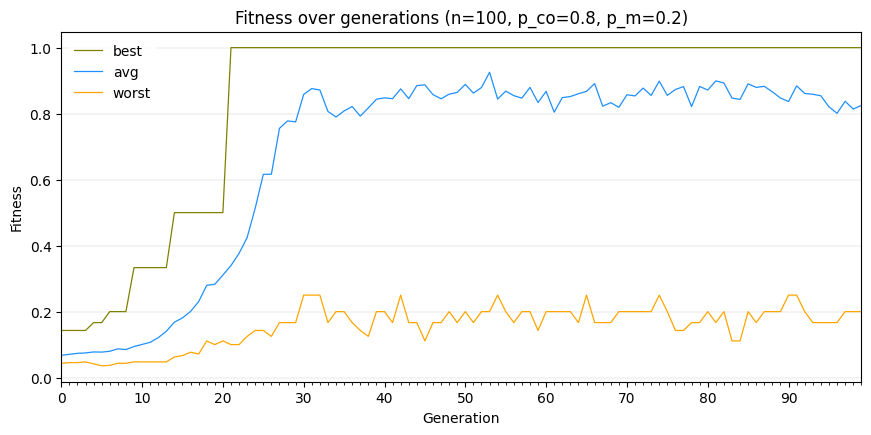

[1 4 0 0 1 3 4 0 0 4 1 2 2 3 2 2 3 3 2 0 2 2 1] True (5)
poprawne znalezione w 21 generacjach (0.1415s)


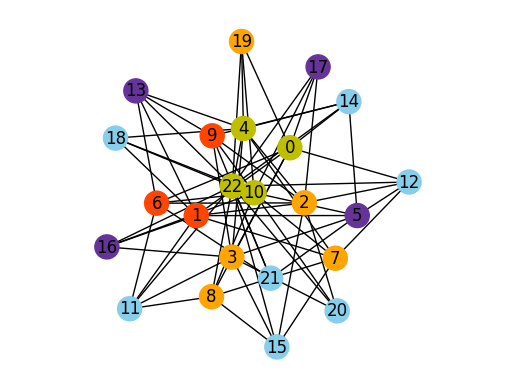

(21, 0.14145278930664062)

In [14]:
optimize(myciel(4), graph_plot=True)

# Badania 1 - Algorytm genetyczny
rozwiązywany problem to __Mycielski-4__ z bazy kolorowania grafów DIMACS

### operatory
- selekcja ruletkowa
- krzyżowanie jednopunktowe
- losowa mutacja jednego genu

### parametry domyślne
- wielkość populacji: 100
- liczba iteracji: 100
- prawdopodobieństwo krzyżowania: 0.5
- prawdopodobieństwmo mutacji: 0.1

## Plan badań
1. Wpływ wielkości populacji 
    - badane wielkości: 10, 50, 100, 500, 1000
2. Wpływ krzyżowania
    - badane prawdopodobieństwo wystąpienia krzyżowania: 0, 0.1, 0.3, 0.5, 0.8, 1
3. Wpływ mutacji 
    - badane prawdopodobieństwo wystąpienia mutacji: 0, 0.1, 0.2, 0.5, 1
4. Zachowanie algorytmu w różnych fazach 
    - badana liczba iteracji: 10, 50, 100, 500, 2000


## 1.1 Wpływ wielkości populacji
### Wnioski
- im większa populacja, tym szybciej i częściej znajdowane poprawne rozwiązanie (w 100 iteracjach)
- w małej populacji niewielkie różnice między najlepszym i najgorszym osobnikiem (parokrotnie takie samo przystosowanie)
- średnie przystosowanie bedziej zbliżone do najlepszego osobnika niż do najgorszego
- im większa populacja, tym mniej rozedrgany wykres
- im większa populacja, tym rzadziej zdarza się "gubienie" najlepszego osobnika

In [14]:
test_cases = [10, 50, 100, 500, 1000]
analysis(myciel(4), 10, test_cases, 'n')

n
					 10		50		100		500		1000
prawidłowych rozwiązań / 10 prób 	 0		7		9		10		10
prawidłowe rozwiązanie po n iteracjach 	 -1.00		68.14		37.22		20.90		13.80




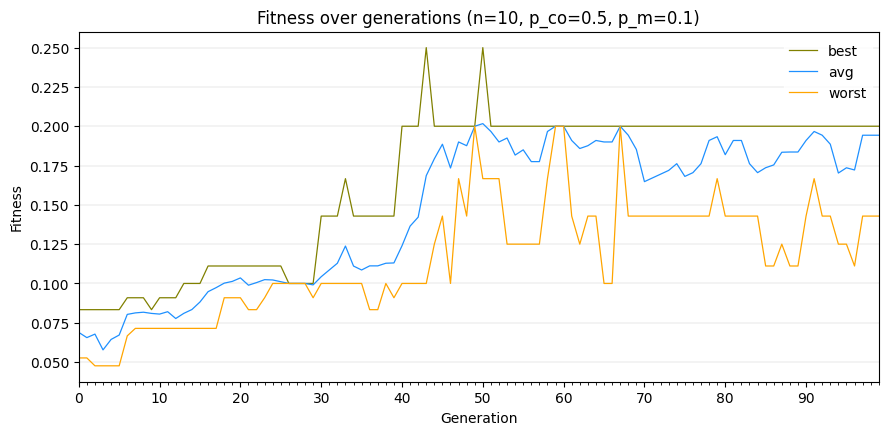

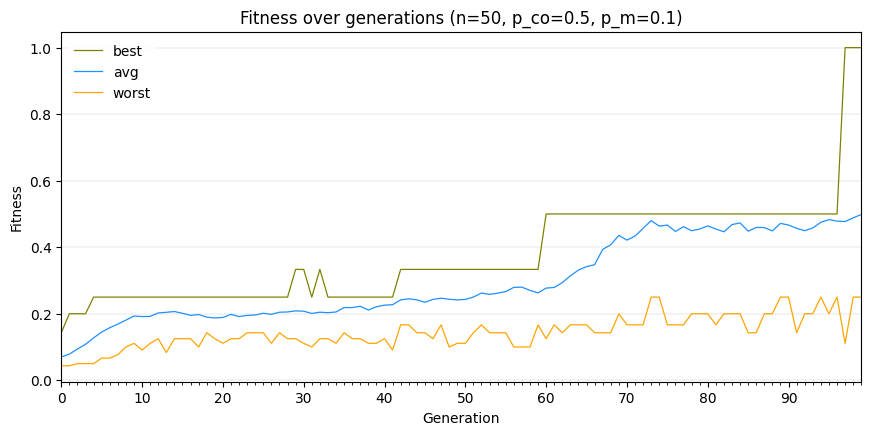

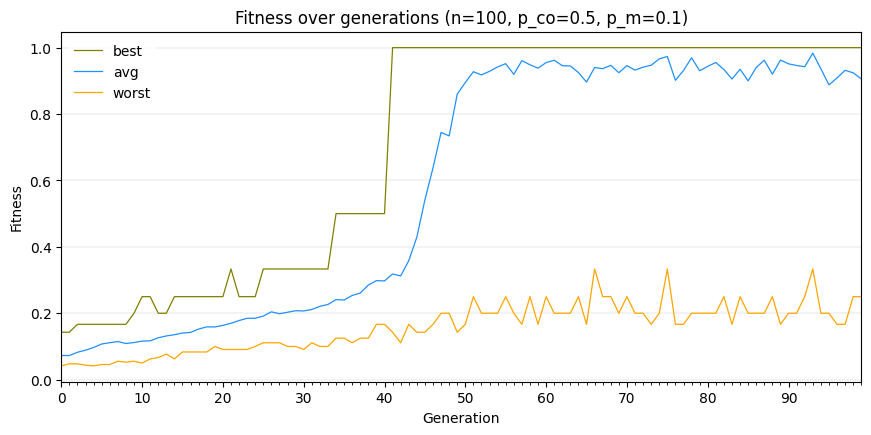

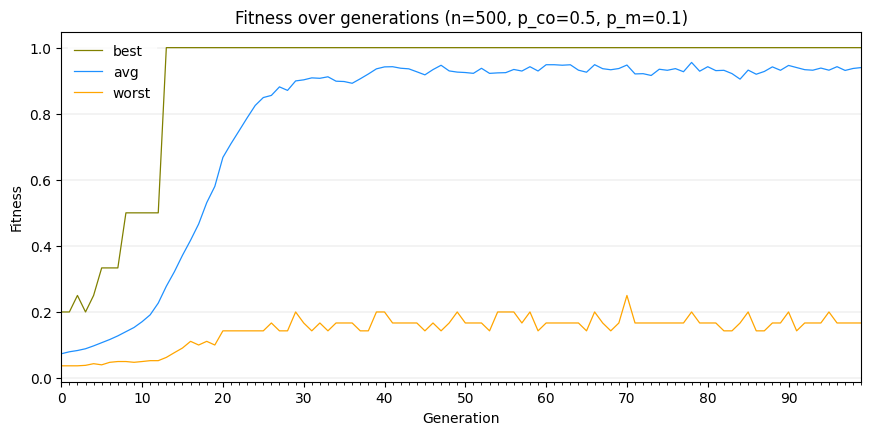

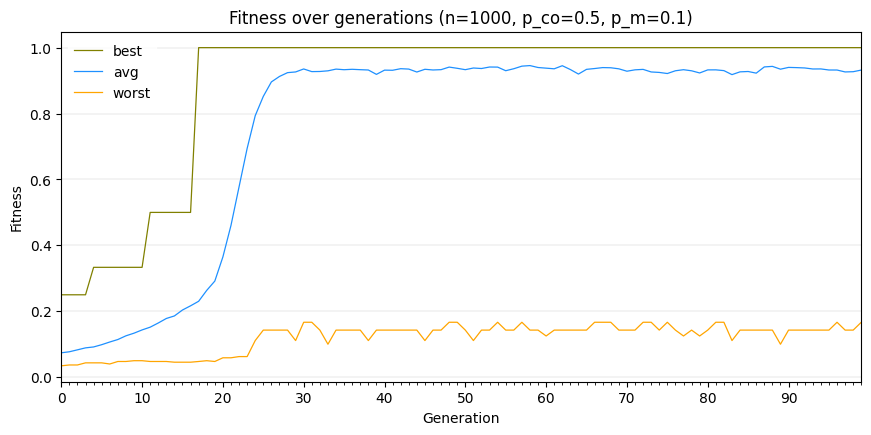

In [15]:
for tc in test_cases:
    optimize(myciel(4), n=tc)

## 1.2 Wpływ krzyżowania
### Wnioski
- prawidłowe rozwiązania najszybciej były znajdowane przy 100% prawdopodobieństwie krzyżowania
- im większe prawodopodobieństwo krzyżowania, tym bardziej stromy wykres średniego przystosowania populacji
- im większe prawodopodobieństwo krzyżowania, tym częściej najlepszy osobnik był "gubiony"

In [45]:
test_cases = [0, 0.1, 0.3, 0.5, 0.8, 1]
analysis(myciel(4), 10, test_cases, 'p_co')

p_co
			 0		0.1		0.3		0.5		0.8		1
prawidłowych / 10 prób 	 9		8		9		10		9		10
rozwiązanie po n iter 	 64.22		57.38		45.22		28.50		36.00		25.00




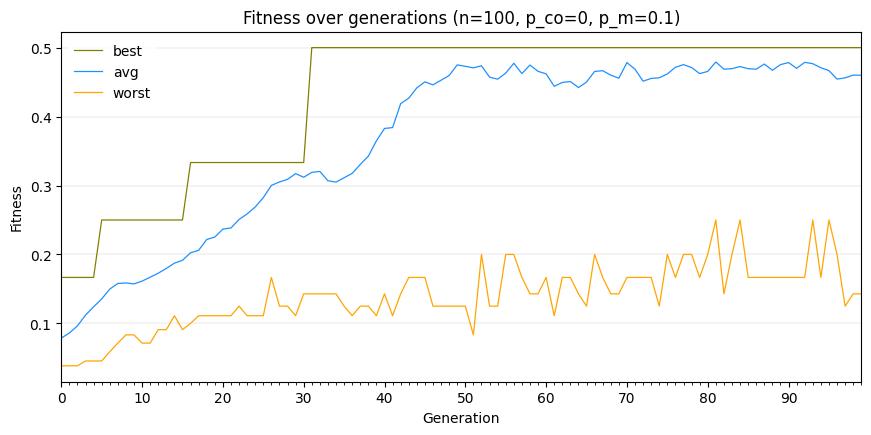

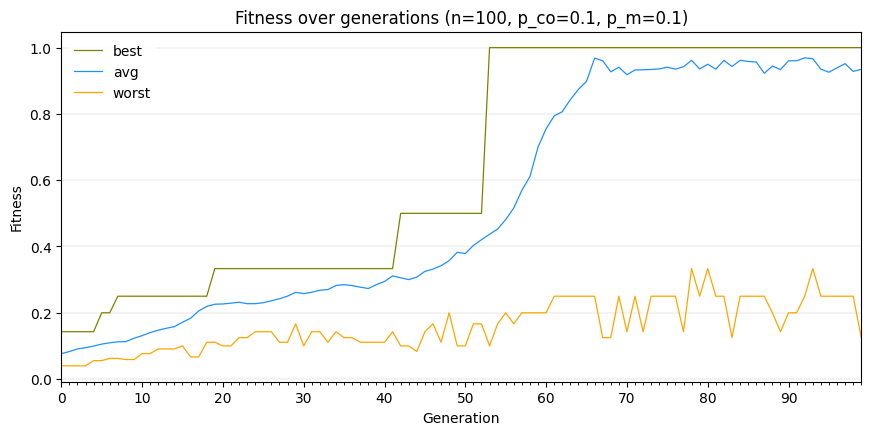

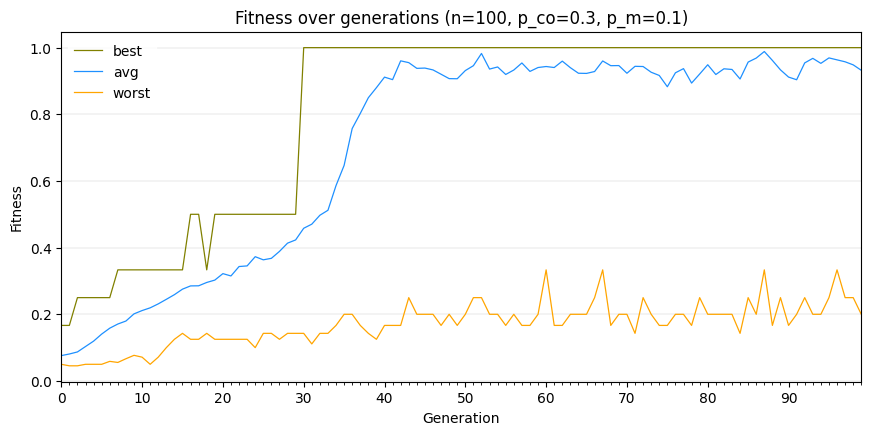

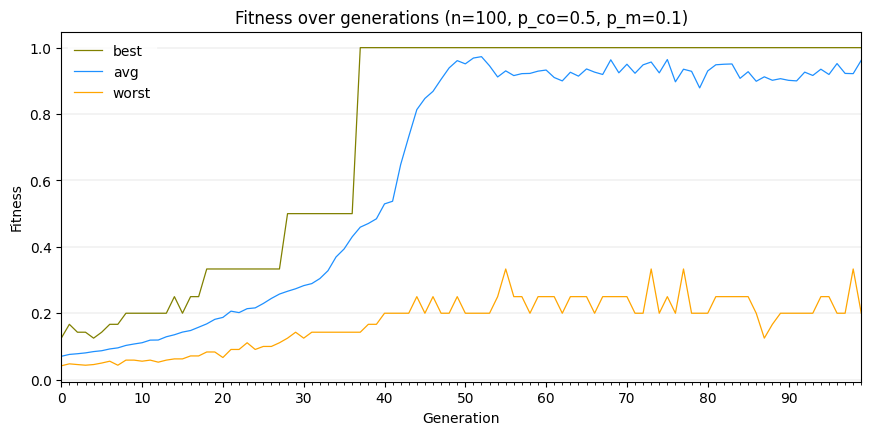

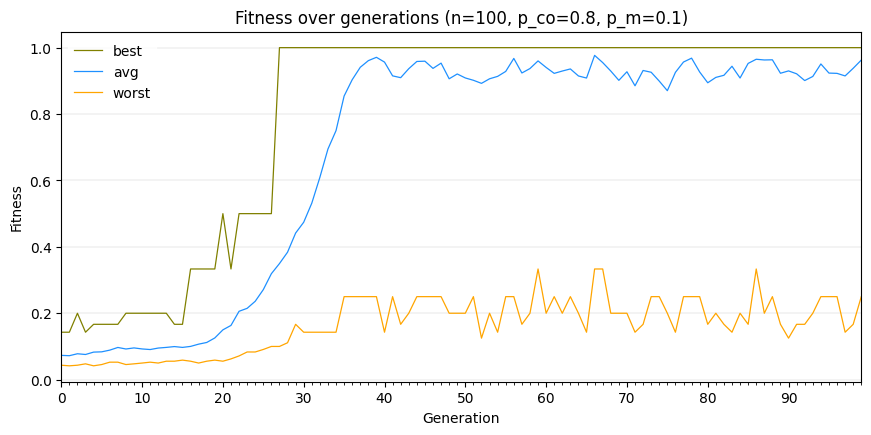

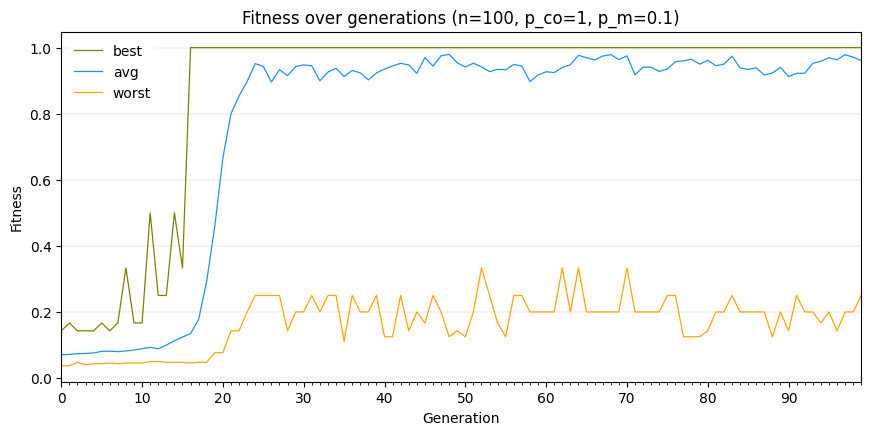

In [46]:
for tc in test_cases:
    optimize(myciel(4), p_co=tc)

## 1.3 Wpływ mutacji
### Wnioski
- prawidłowe rozwiązania najszybciej były znajdowane przy 20% prawdopodobieństwie mutacji
- bez operatora mutacji, po ok. 35 iteracjach, wszystkie osobniki są tak samo przystosowane i nie powstają nowe rozwiązania
- wysokie prawdopodobieństwo mutacji bardzo obniża średnie przystosowanie populacji, a najlepsze osobniki często są "gubione"

In [18]:
test_cases = [0, 0.1, 0.2, 0.5, 1]
analysis(myciel(4), 10, test_cases, 'p_m')

p_m
					 0		0.1		0.2		0.5		1
prawidłowych rozwiązań / 10 prób 	 2		10		10		10		10
prawidłowe rozwiązanie po n iteracjach 	 24.50		40.20		28.00		29.90		34.60




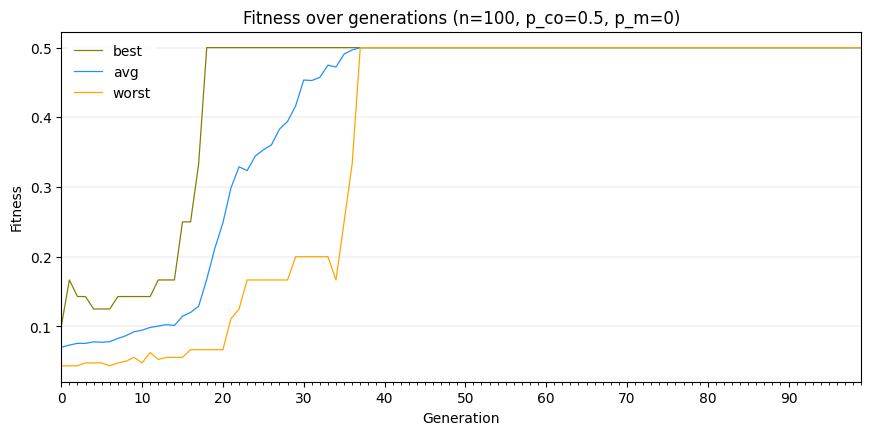

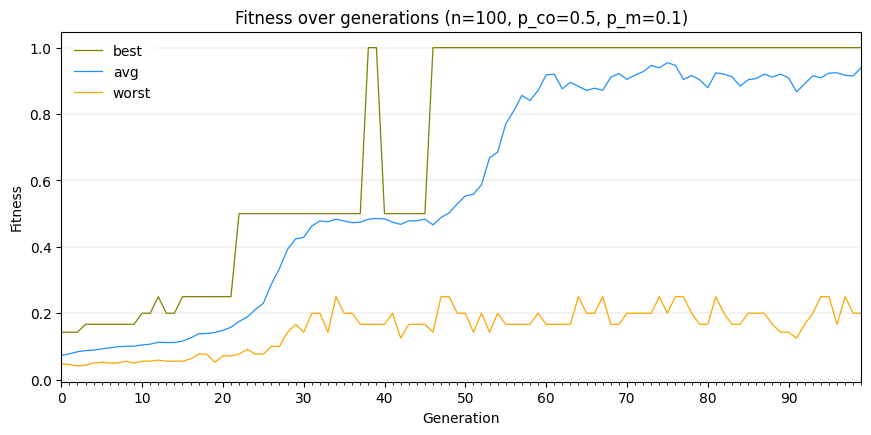

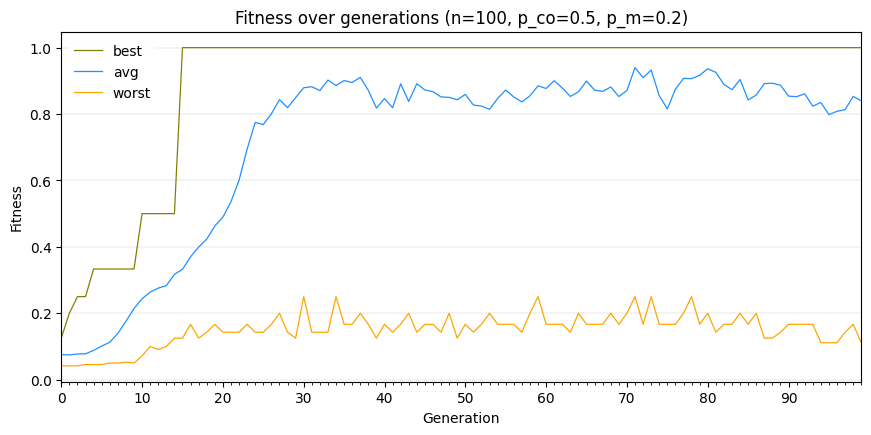

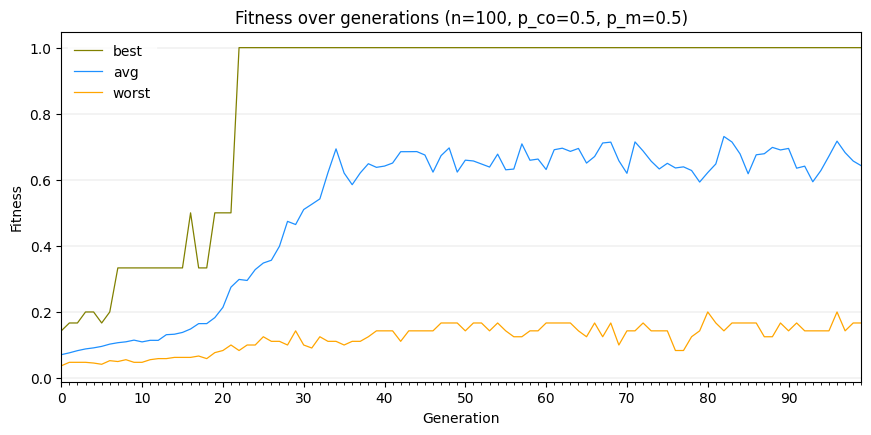

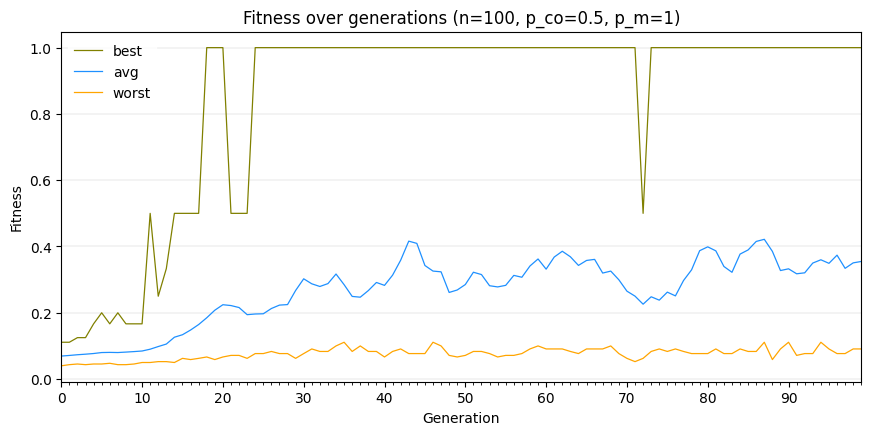

In [19]:
for tc in test_cases:
    optimize(myciel(4), p_m=tc)

## 1.4 Zachowanie algorytmu w różnych fazach
### Wnioski
- przez pierwsze 10 iteracji następuje niewielka zmiana w średnim przystosowaniu populacji i jest duża zmienność w przystosowaniu najlepszego osobnika
- pierwsze 50 iteracji to najistotniejszy etap w optymalizacji - znaleziony zostaje najlepszy osobnik, a średnie przystosowanie znacząco rośnie
- po 50 iteracjach nie następują zmiany w przystosowaniu najlepszego osobnika, a wykresy średniego przystosowania i najgorszego osobnika, mimo że są bardzo rozedrgane, nie zmieniają trendu 

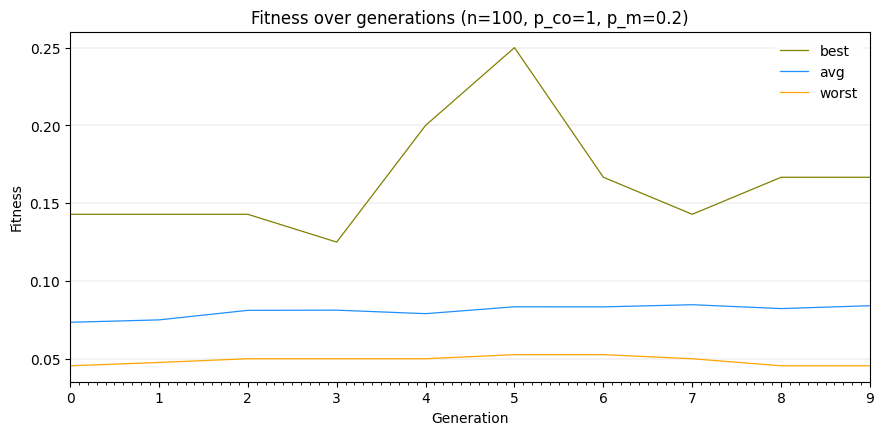

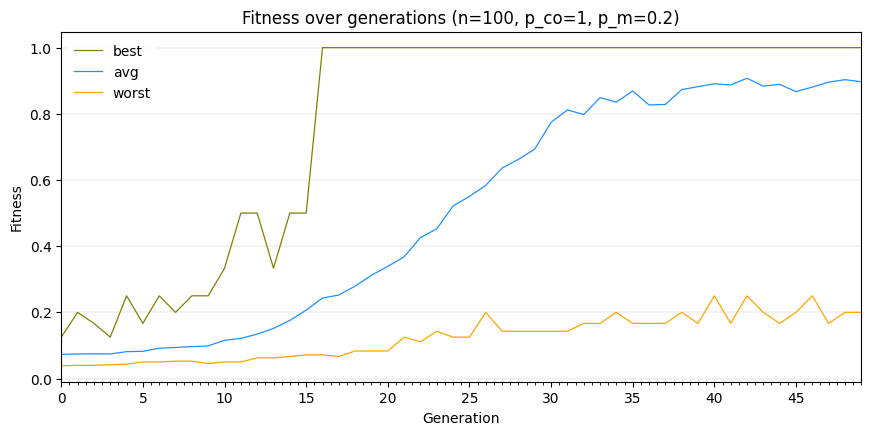

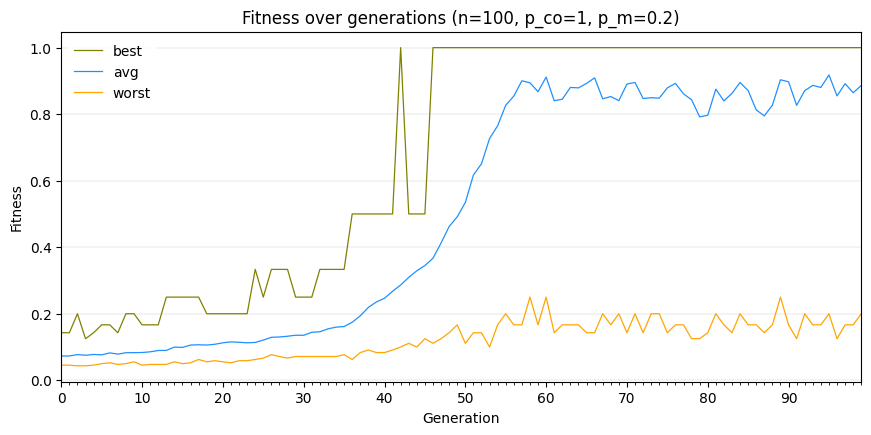

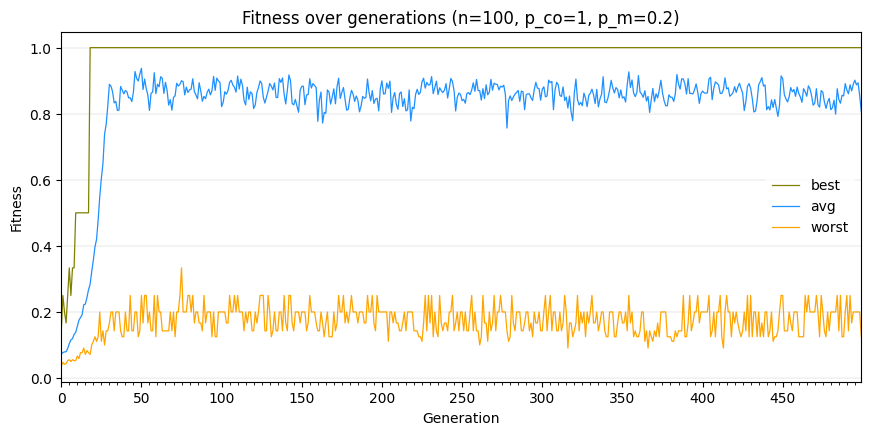

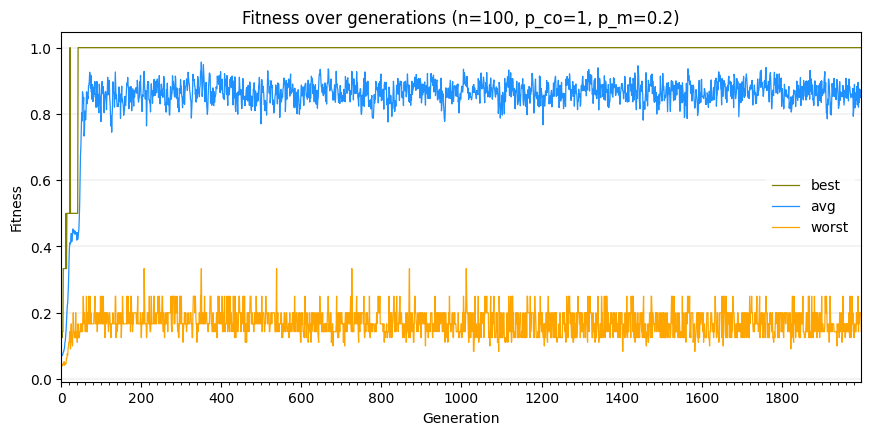

In [48]:
test_cases = [10, 50, 100, 500, 2000]
for tc in test_cases:
    optimize(myciel(4), n=100, iterations=tc, p_co=1, p_m=.2)

# Badania 2 - Operatory genetyczne
rozwiązywany problem to __Mycielski-4__ z bazy kolorowania grafów DIMACS

### parametry
- wielkość populacji: 100
- liczba iteracji: 100
- prawdopodobieństwo krzyżowania: 0.8
- prawdopodobieństwmo mutacji: 0.2

### operatory domyślne
- selekcja ruletkowa
- krzyżowanie jednopunktowe
- losowa mutacja jednego genu

## Plan badań
1. Wpływ operatora selekcji
    - selekcja losowa
    - selekcja ruletkowa
    - selekcja turniejowa: 1, 20, 50, 100
    - uniwersalne próbkowanie stochastyczne
2. Wpływ operatora krzyżowania
    - krzyżowanie jednopunktowe
    - krzyżowanie dwupunktowe
    - krzyżowanie wielopunktowe: 3, 5, 10
    - kryżowanie równomierne
3. Wpływ operatora mutacji 
    - losowa mutacja jednego genu
    - zamiana dwóch genów
    - losowe wymieszanie części genotypu
    - inwersja części genotypu

## 2.1 Wpływ operatora selekcji
### Wnioski
- przy zastosowaniu operatora, który **losowo** wybiera osobniki, nie następuje poprawa przystosowania w kolejnych iteracjach działania algorytmu
- operator turniejowy o **turnieju wielkości 1** jest równoważny selekcji losowej 
- prawidłowe rozwiązanie jest najszybciej znajdowane przy użyciu selekcji turniejowej, gdzie **turniej jest wielkości połowy populacji**
- turniej o wielkości całej populacji jest równoważny **elityzmowi** - zawsze zostaną wybrane najlepsze osobniki i nie można zauważyć spadku przystosowania najlepszego osobnika; _rozwój_ całej populacji jest spowolniony w stosunku do innych strategii
- **uniwersalne próbkowanie stochastyczne** daje lepsze wyniki niż ruletka; osobnik o najlepszym przystosowaniu jest znajdowany wolniej, niż w przypadku turnieju (20, 50), ale za każdym razem

In [82]:
test_cases = ['random', 'roul', 't1', 't.2', 't.5', 't1', 'sus']
analysis(myciel(4), 10, test_cases, 's_op')

s_op
			 random		roul		t1		t20		t50		t100		sus
prawidłowych / 10 prób 	 0		10		0		9		9		10		10
rozwiązanie po n iter 	 -1.00		31.00		-1.00		17.33		7.67		27.20		23.90




random


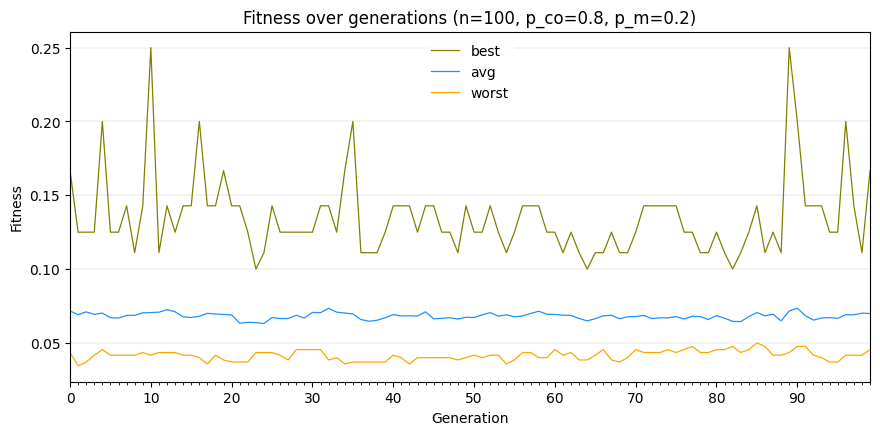

roul


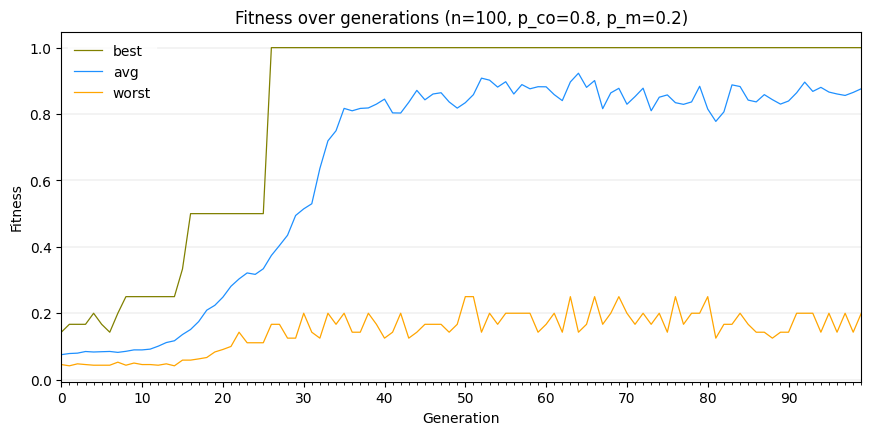

t1


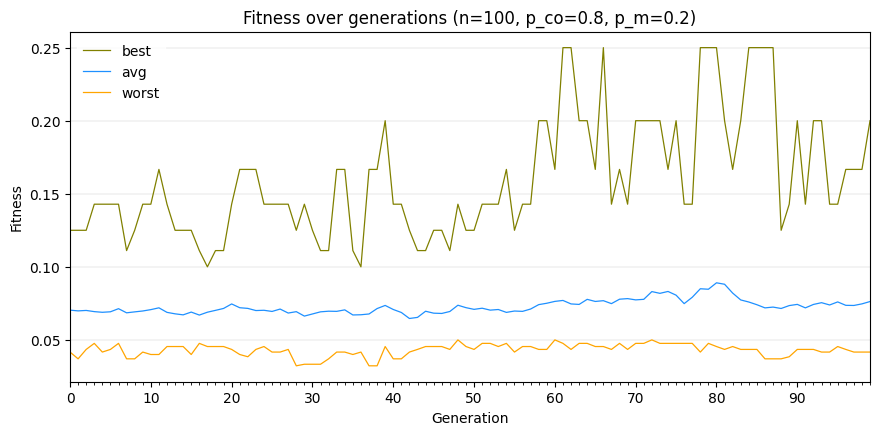

t20


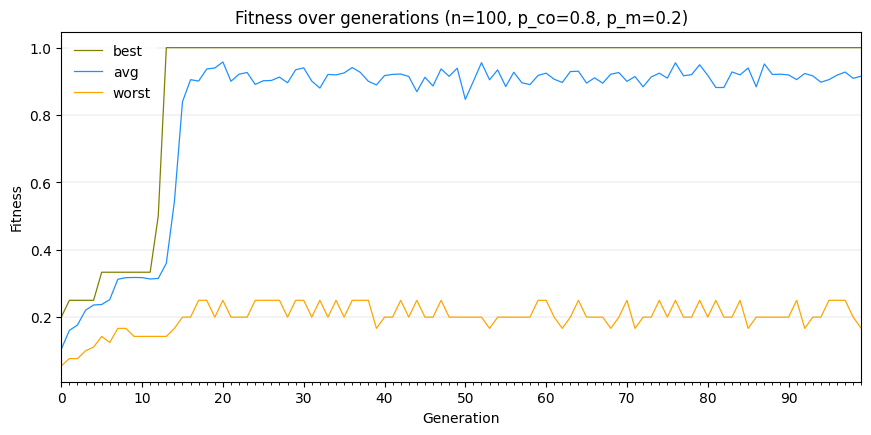

t50


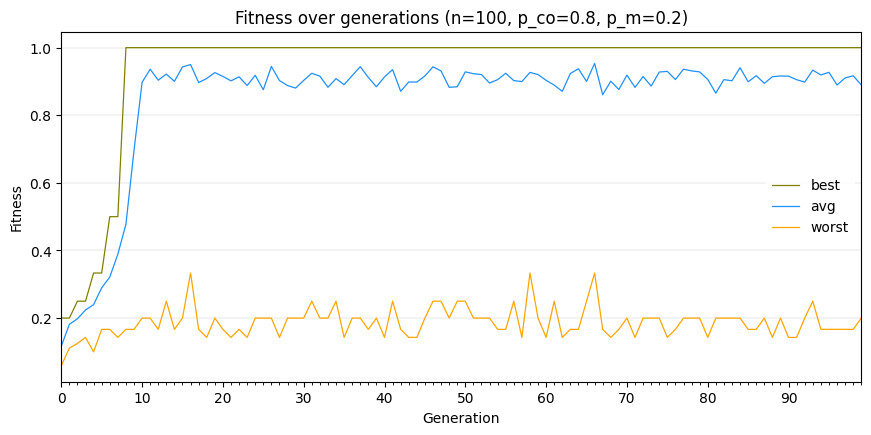

t100


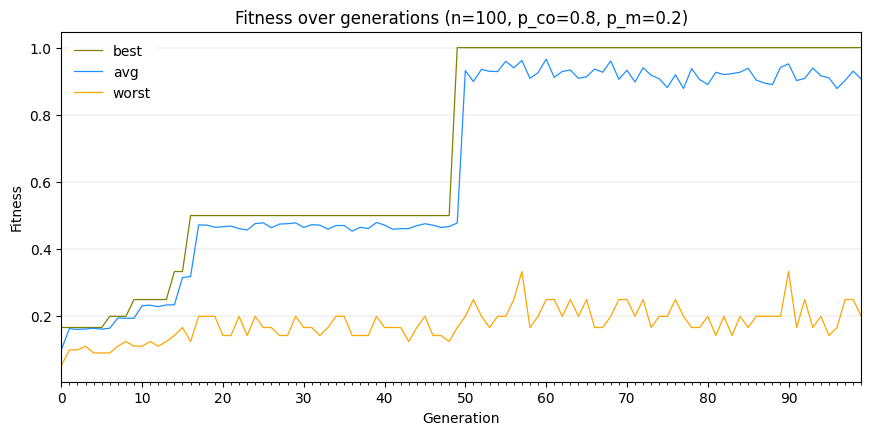

sus


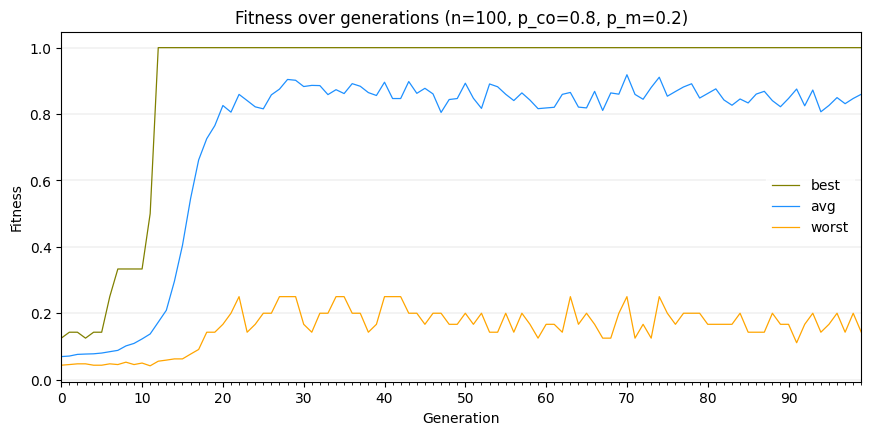

In [84]:
for tc in test_cases:
    print(tc)
    optimize(myciel(4), s_op=tc)

## 2.2 Wpływ operatora krzyżowania
### Wnioski
- wszystkie operatory krzyżowania dają podobne wyniki
- najszybciej znalezione zostały rozwiązania z użyciem krzyżowania wielopunktowego o 5 punktach krzyżowania

In [90]:
test_cases = ['single', 'multi2', 'multi3', 'multi5', 'multi10', 'uniform']
analysis(myciel(4), 10, test_cases, 'co_op')

co_op
			 single		multi2		multi3		multi5		multi10		uniform
prawidłowych / 10 prób 	 10		10		10		10		10		10
rozwiązanie po n iter 	 21.50		23.60		22.10		18.30		24.60		23.90




single


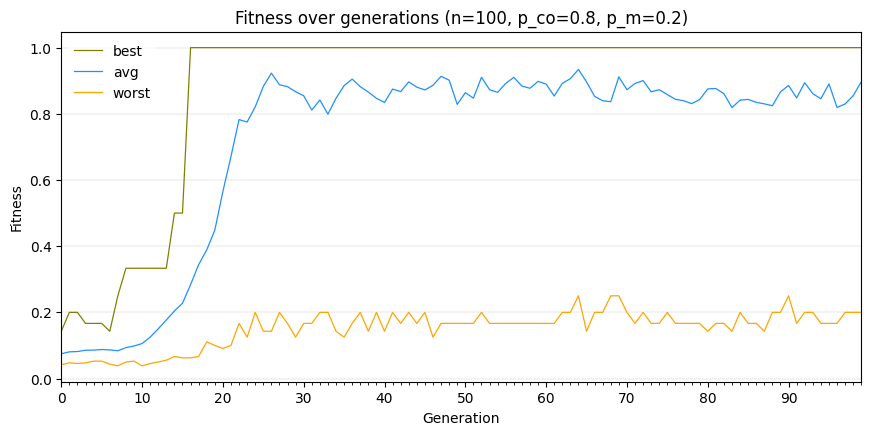

multi2


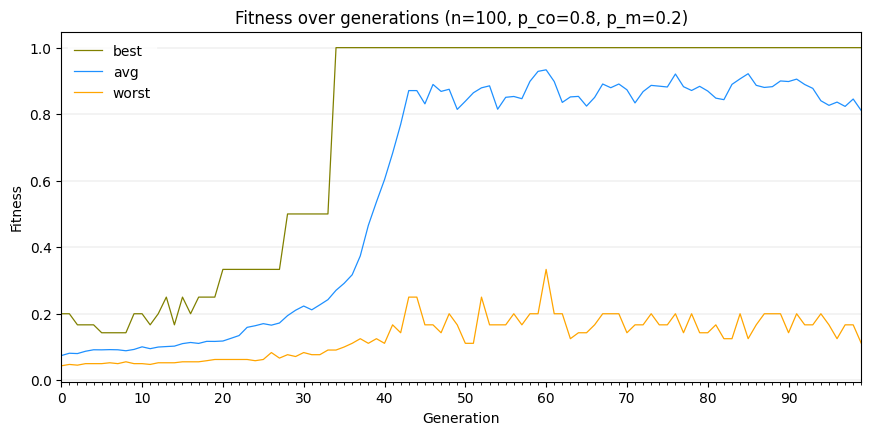

multi3


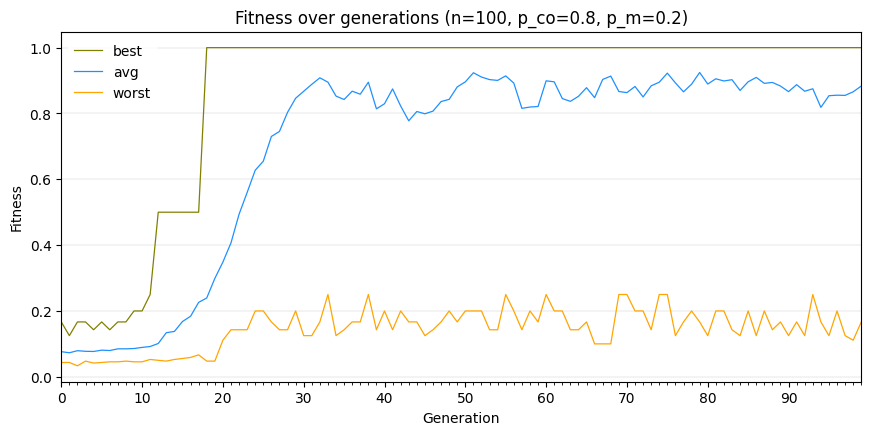

multi5


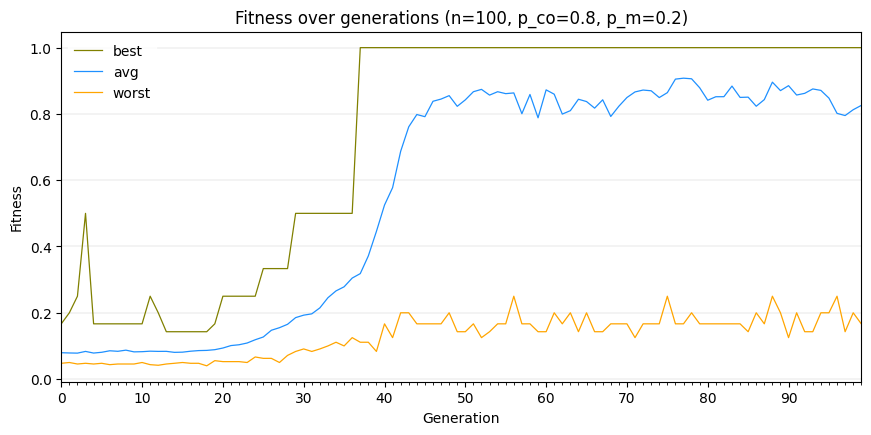

multi10


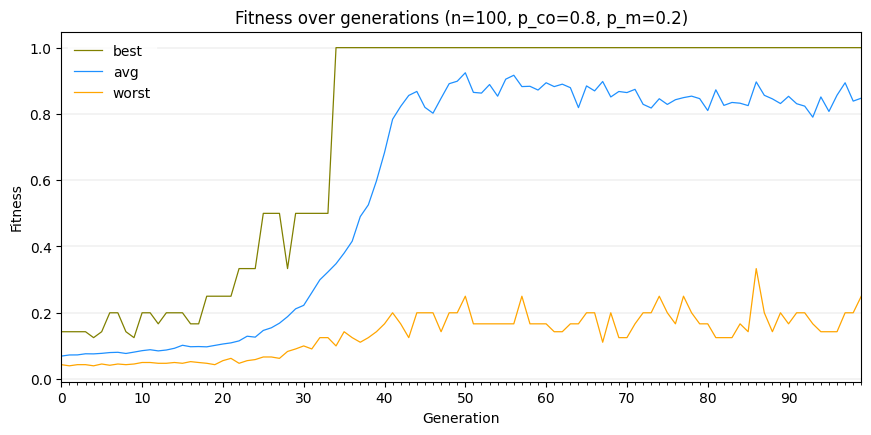

uniform


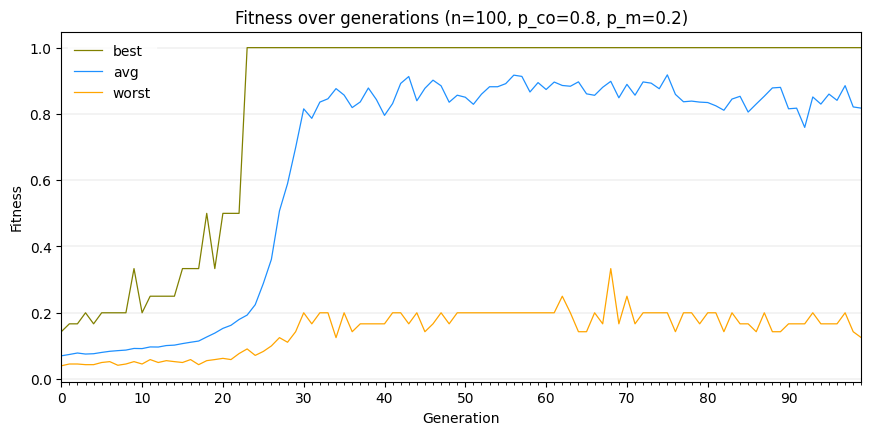

In [91]:
for tc in test_cases:
    print(tc)
    optimize(myciel(4), co_op=tc)

## 2.3 Wpływ operatora mutacji
### Wnioski
- operator **zamiany dwóch losowych genów** (*swap*) pozwolił na najszybsze znalezienie rozwiązania
- wszystkie operatory mutacji dały podobnie dobre wyniki
- najwolniej rozwiązanie było znajdowane przy zastosowaniu operatora losowego przemieszania części genotypu (*scramble*)

In [131]:
test_cases = ['random', 'swap', 'scramb', 'inversion']
analysis(myciel(4), 10, test_cases, 'm_op')

m_op
			 random		swap		scramb		inversion
prawidłowych / 10 prób 	 10		10		10		8
rozwiązanie po n iter 	 27.70		26.60		33.80		28.62
czas 			 0.1863		0.1696		0.2146		0.1872




random


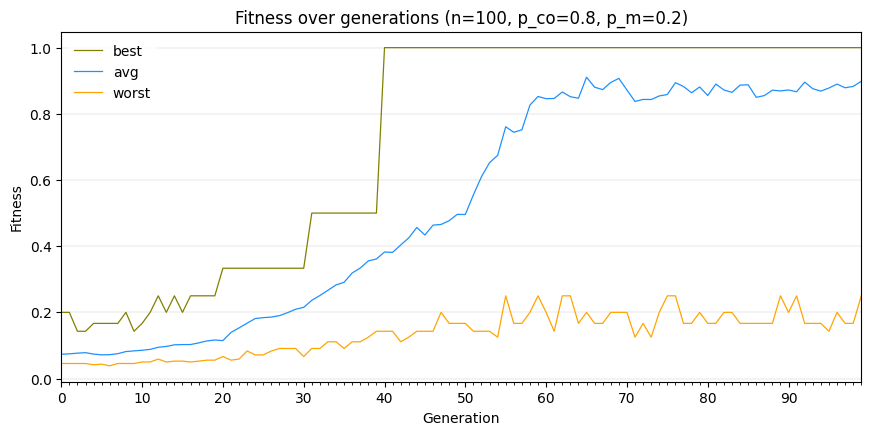

swap


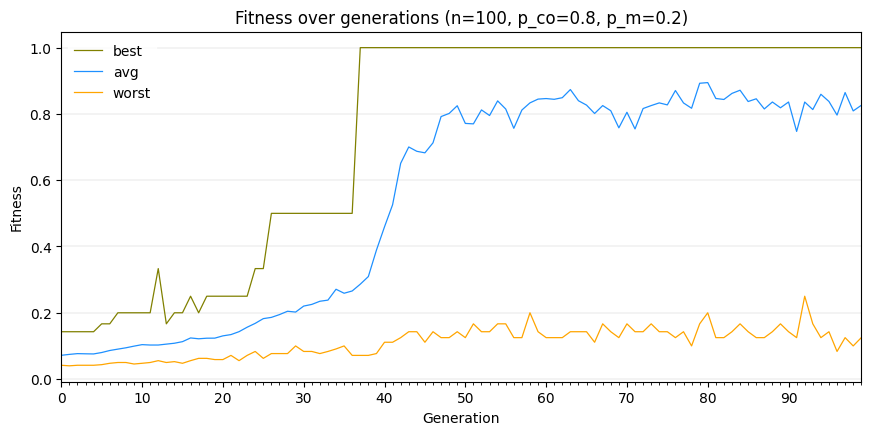

scramble


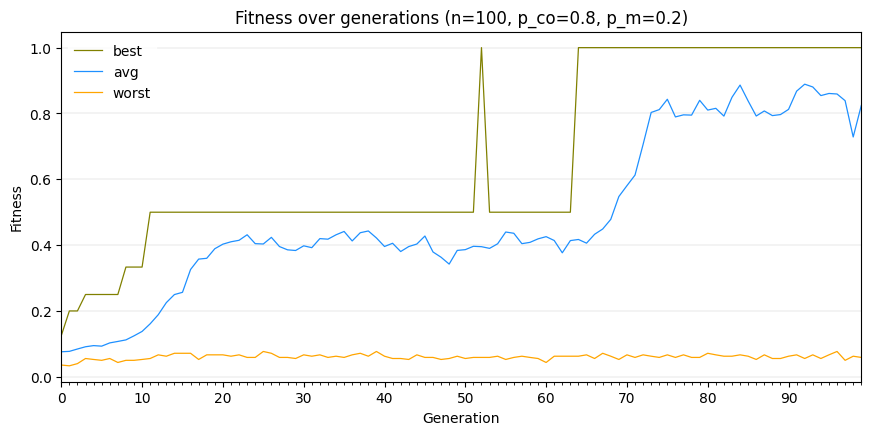

inversion


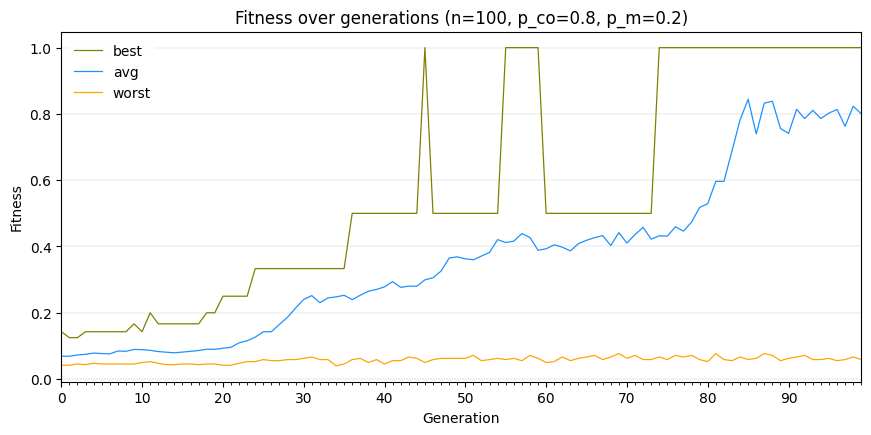

In [99]:
for tc in test_cases:
    print(tc)
    optimize(myciel(4), m_op=tc)

## 3 Benchmark
Na podstawie przeprowadzonych badań wybrałam najlepszy zestaw parametrów, a następnie porównałam wynik algorytmu genetycznego z wynikami innych algorytmów stosowanych do rozwiązywania problemu kolorowania grafu

### operatory
- selekcja turniejowa (turniej wielkości połowy populacji)
- krzyżowanie wielopunktowe (5 punktów krzyżowania)
- mutacja przez zamianę dwóch losowych genów

### parametry 
- wielkość populacji: 100
- liczba iteracji: 100
- prawdopodobieństwo krzyżowania: 0.8
- prawdopodobieństwmo mutacji: 0.2

In [2]:
def benchmark(gcp, i, instance_name):
    gens = []
    times = []
    
    n=100
    iterations=100
    
    s_op='t.5'
    co_op='multi5'
    m_op='swap'
    
    p_co=.8
    p_m=.2

    for _ in range(i):
        best_gen, best_time = optimize(gcp, n=n, iterations=iterations, 
                            s_op=s_op, co_op=co_op, m_op=m_op, 
                            p_co=p_co, p_m=p_m,
                            is_plot=False)
        if(best_gen):
            gens.append(best_gen)
            times.append(best_time)

    found_count = len(gens)
    if found_count:
        avg_gens = sum(gens) / len(gens)
        avg_times = sum(times) / len(times)

        print(f'{instance_name}: {n} osobników, {iterations} iteracji\noperator selekcji turniejowej k={n//2} \noperator krzyżowania pięciopunktowego p={p_co} \noperator mutacji - losowa zamiana dwóch genów p={p_m}')
        print()
        print(f'rozwiązania znaleziono w {found_count} / {i} prób')
        print(f'rozwiązania znaleziono średnio po {avg_gens} iteracjach ({avg_times:.4f}s)')
        print(f'najlepszy czas {min(times):.4f}s')
        print()
    else:
        print(f'{instance_name}: {n} osobników, {iterations} iteracji\noperator selekcji turniejowej k={n//2} \noperator krzyżowania pięciopunktowego p={p_co} \noperator mutacji - losowa zamiana dwóch genów p={p_m}')
        print()
        print(f'nie znaleziono rozwiązania w {i} próbach')

In [136]:
benchmark(myciel(4), 100, 'myciel(4)')

myciel(4) 100 osobników, 100 iteracji
operator selekcji turniejowej k=50 
operator krzyżowania pięciopunktowego p=0.8 
operator mutacji - losowa zamiana dwóch genów p=0.2

rozwiązania znaleziono w 98 / 100 prób
rozwiązania znaleziono średnio po 12.428571428571429 iteracjach (0.1036s)
najlepszy czas 0.0192s



In [21]:
benchmark(myciel(5), 100, 'myciel(5)')

myciel(5): 100 osobników, 100 iteracji
operator selekcji turniejowej k=50 
operator krzyżowania pięciopunktowego p=0.8 
operator mutacji - losowa zamiana dwóch genów p=0.2

rozwiązania znaleziono w 66 / 100 prób
rozwiązania znaleziono średnio po 45.515151515151516 iteracjach (0.6141s)
najlepszy czas 0.1866s



In [151]:
benchmark(queen(5), 100, 'queen(5)')

queen(5): 100 osobników, 100 iteracji
operator selekcji turniejowej k=50 
operator krzyżowania pięciopunktowego p=0.8 
operator mutacji - losowa zamiana dwóch genów p=0.2

nie znaleziono rozwiązania w 100 próbach


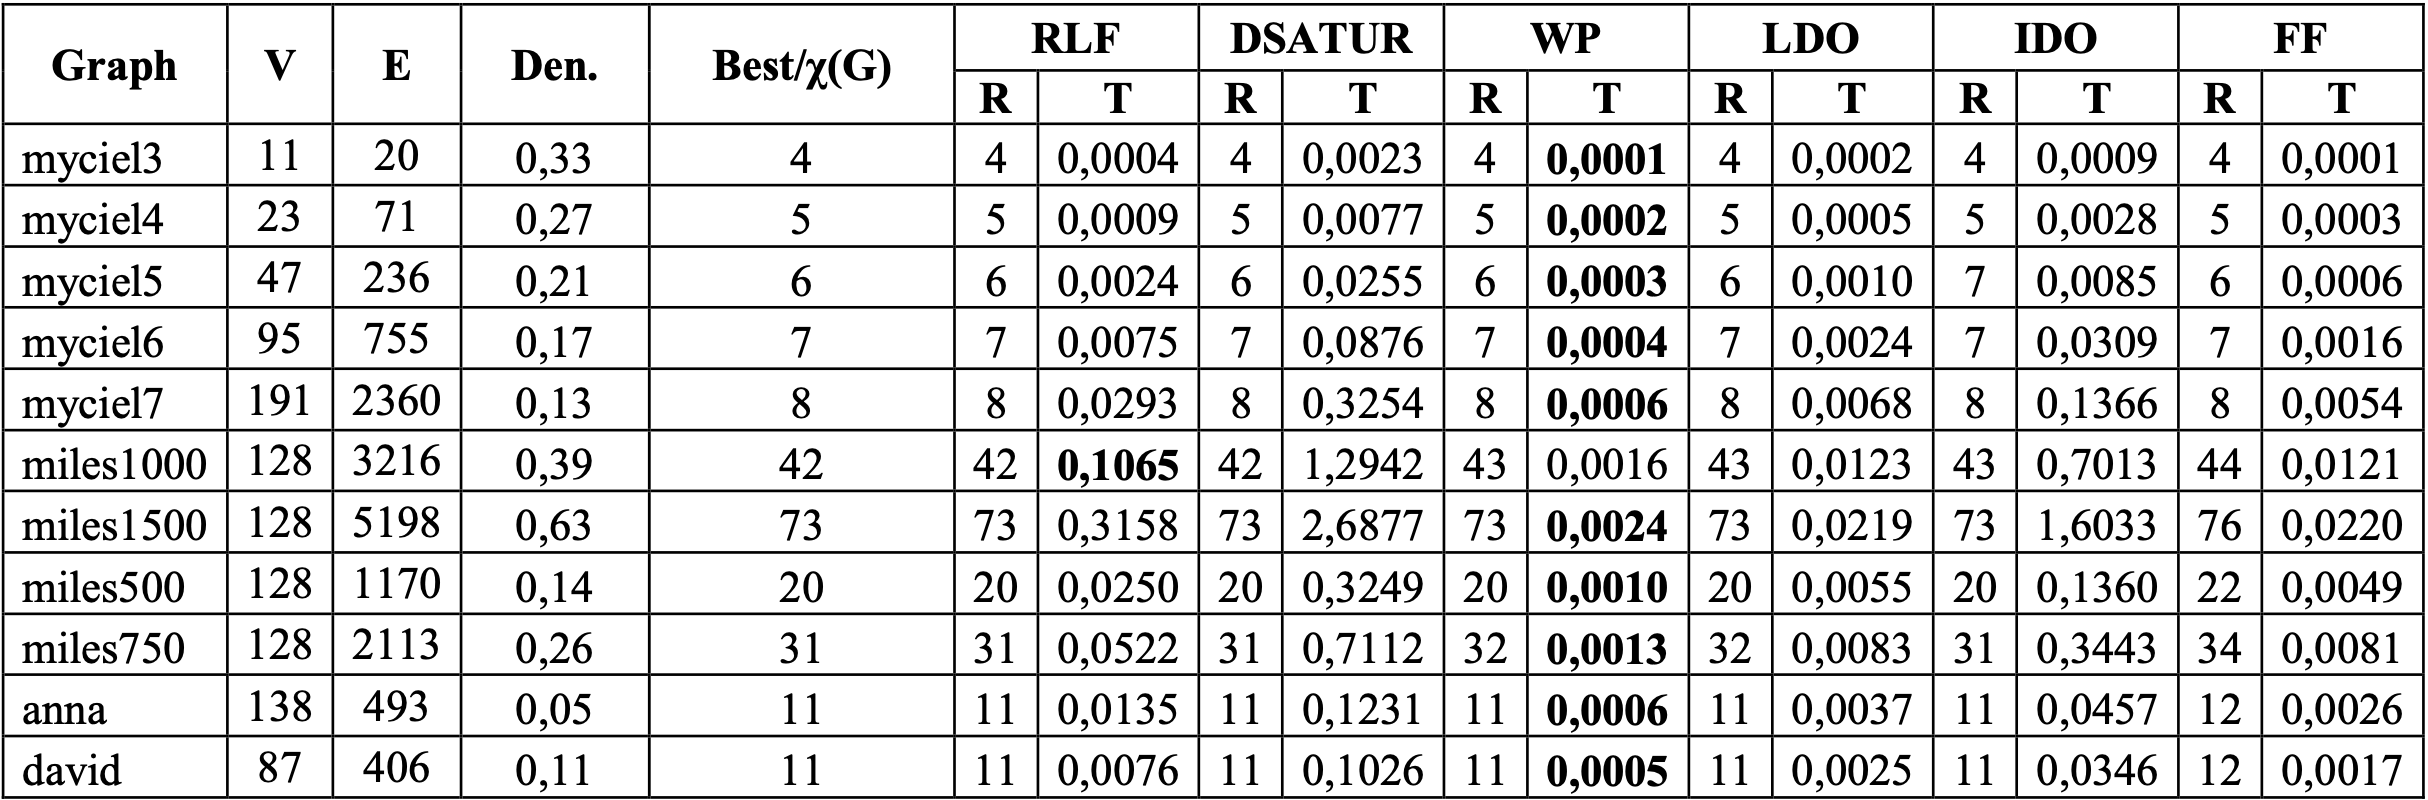

In [158]:
Image(filename='../myciel.png') 

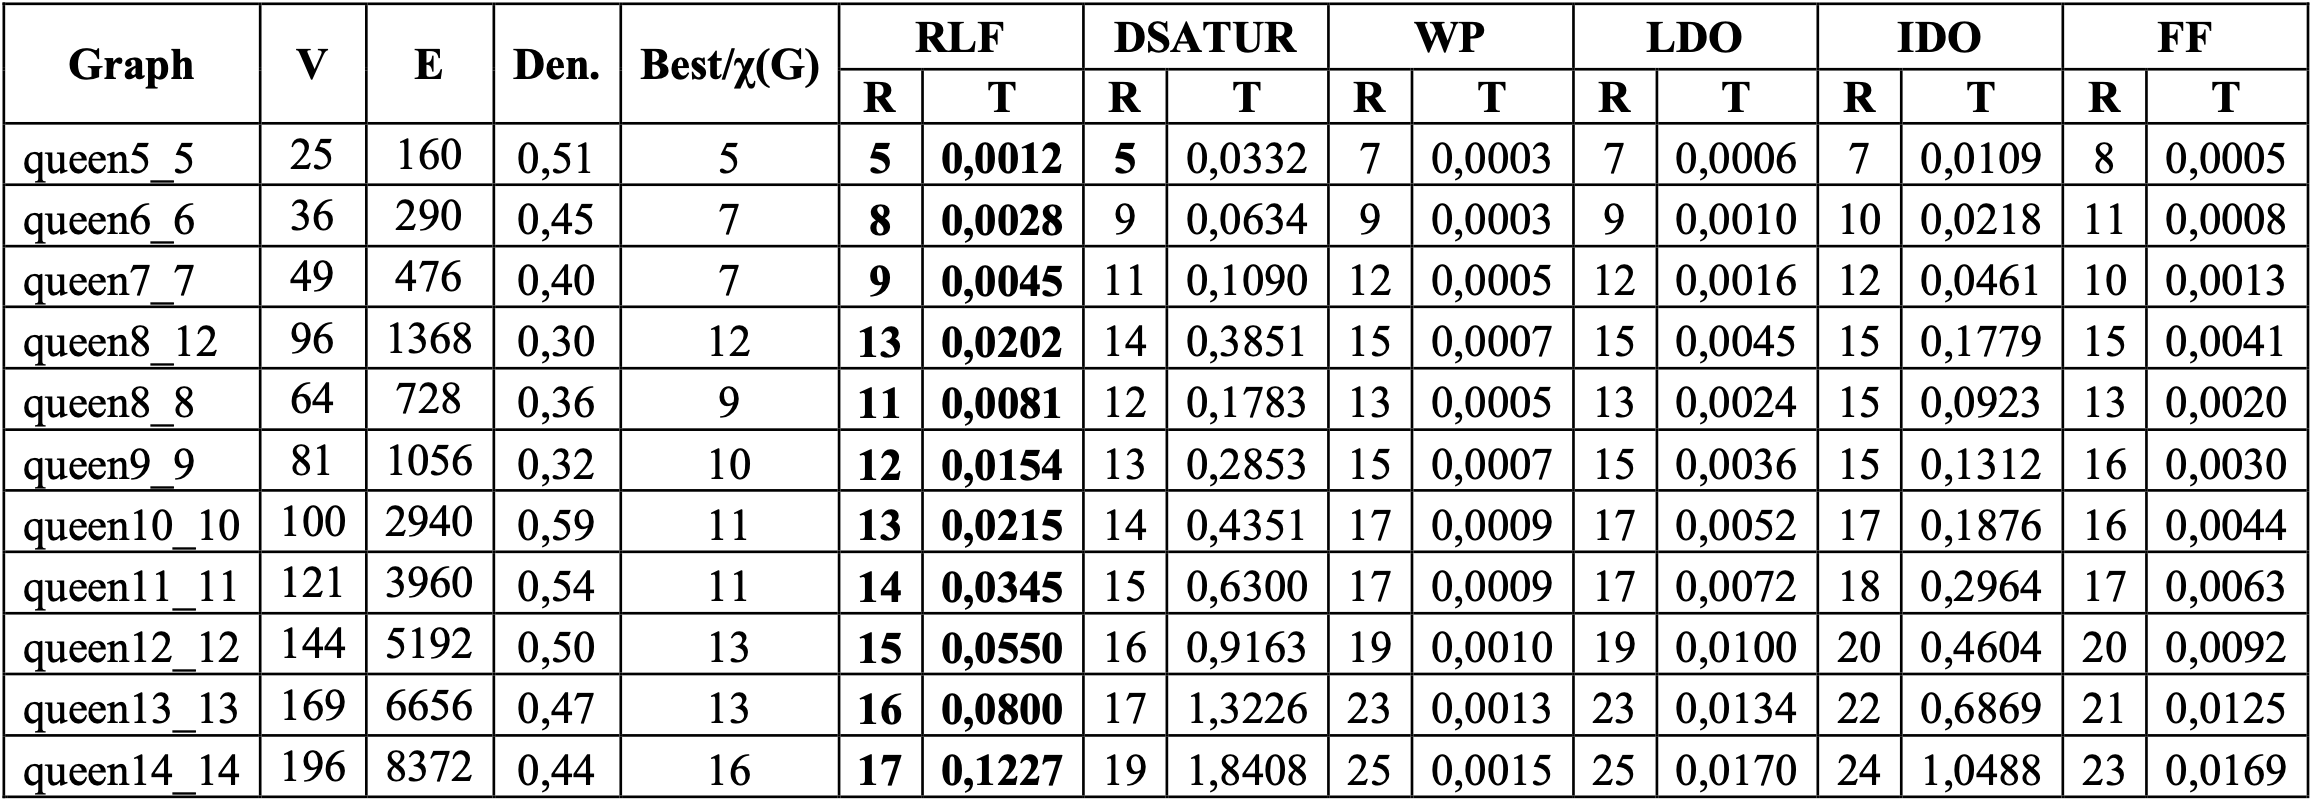

In [157]:
Image(filename='../queen.png') 